Identify genes that have no information whatsoever in identifying clusters.

**Unsupervised**
* Genes that hardly affect K-means clustering
* Genes that are considered noise according to Marcenko-Pastur

**Supervised**
* univariate differential expression over the meta-classes
* multivariable feature selection method over the meta-classes
* inverse: meta-classes as independent variables that influence gene expression -> select low-predictive outcomes

In [51]:
import os
import pandas as pd
import scipy as sc
import numpy as np
from tqdm import tqdm

import seaborn as sns

import timeit

import matplotlib.pyplot as plt

from sklearn.preprocessing import QuantileTransformer

In [2]:
os.chdir("/media/koekiemonster/DATA-FAST/genetic_expression/lung_cancer_2021/TCGA")

In [3]:
rna_expression = pd.read_feather("Lung_RNAex.feather")
rna_expression.set_index('index', inplace=True)
meta_data = pd.read_feather("Lung_meta.feather")
meta_data.set_index('SampleID', inplace=True)

In [4]:
sel = np.random.randint(0,60000)
cond = (rna_expression.iloc[:,sel]>0).sum()>500

if cond:
    np.log10(rna_expression.iloc[:,sel]+1).plot.hist(bins=50)
    plt.show()
    print(rna_expression.columns[sel])

In [5]:
nzl = []
for c in tqdm(rna_expression.columns):
    nzl.append({'gene': c, 'non_zero_num': (rna_expression.loc[:,c]>0).sum()})
nzl_df = pd.DataFrame(nzl)

100%|██████████| 60465/60465 [00:17<00:00, 3542.33it/s]


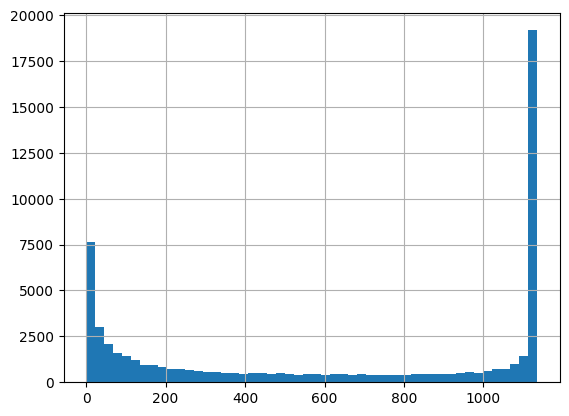

In [6]:
nzl_df.non_zero_num.hist(bins=50)
plt.show()

In [7]:
min_nzl = int(rna_expression.shape[0]/2)
keep_genes = nzl_df.loc[nzl_df.non_zero_num>min_nzl, 'gene'].values

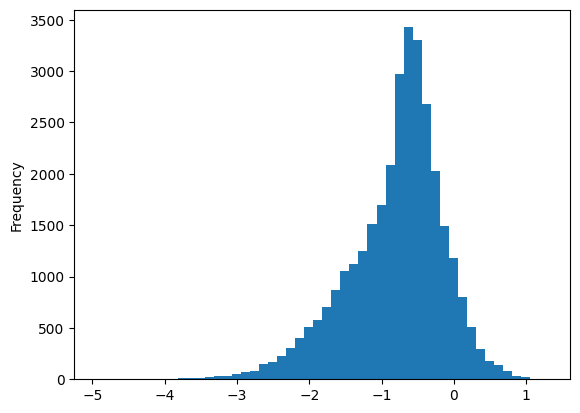

In [8]:
(np.log10(rna_expression.loc[:, keep_genes].var())).plot.hist(bins=50)
plt.show()

# Housekeeping genes

In [9]:
X_raw = rna_expression.loc[:, keep_genes]

gene_var_matrix = pd.DataFrame({'gene_var': np.log10(X_raw+1).var(),
                                'gene_median': np.log10(X_raw+1).median(), 
                                'gene_mean': np.log10(X_raw+1).mean(),
                                'gene_entropy': np.log10(X_raw+1).apply(sc.stats.entropy, axis=0)})

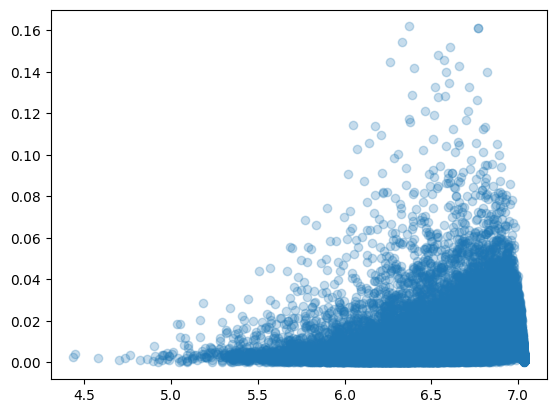

In [10]:
plt.scatter(gene_var_matrix.gene_entropy, gene_var_matrix.gene_var, alpha=0.25)
plt.show()

In [11]:
potential_housekeeping = gene_var_matrix[gene_var_matrix.gene_median>1].index

In [12]:
potential_housekeeping

Index(['ACTB_chr7_5527151_5563784_-', 'ACTG1_chr17_81509971_81523847_-',
       'B2M_chr15_44711477_44718877_+', 'CD74_chr5_150401637_150412929_-',
       'EEF1A1_chr6_73515750_73523797_-', 'FTL_chr19_48965301_48966878_+',
       'GAPDH_chr12_6533927_6538374_+', 'HLA-B_chr6_31353872_31357188_-',
       'HLA-DRA_chr6_32439842_32445046_+', 'IGHA1_chr14_105707118_105708665_-',
       'IGHG1_chr14_105668113_106538344_-', 'IGKC_chr2_88857161_89245596_-',
       'MT-ATP6_chrM_8527_9207_+', 'MT-ATP8_chrM_8366_8572_+',
       'MT-CO1_chrM_5904_7445_+', 'MT-CO2_chrM_7586_8269_+',
       'MT-CO3_chrM_9207_9990_+', 'MT-CYB_chrM_14747_15887_+',
       'MT-ND1_chrM_3307_4262_+', 'MT-ND2_chrM_4470_5511_+',
       'MT-ND3_chrM_10059_10404_+', 'MT-ND4_chrM_10760_12137_+',
       'MT-ND4L_chrM_10470_10766_+', 'MT-ND5_chrM_12337_14148_+',
       'MT-ND6_chrM_14149_14673_-', 'MT-RNR2_chrM_1671_3229_+',
       'PSAP_chr10_71816298_71851369_-', 'RPL13A_chr19_49487554_49492308_+',
       'RPL8_chr8_14478976

In [13]:
# https://housekeeping.unicamp.br/?homePageHuman
housekeeping_genes = ['PSAP_chr10_71816298_71851369_-', 
                      'HLA-B_chr6_31353872_31357188_-',
                      'S100A6_chr1_153534599_153536244_-',
                      'MT-ATP6_chrM_8527_9207_+',
                      'CD74_chr5_150401637_150412929_-',
                      'RPL13A_chr19_49487554_49492308_+',
                      'SFTPB_chr2_85657314_85668741_-',
                      'TMSB4X_chrX_12975108_12977227_+'
                     ]

In [14]:
pipe = ['log', 'standardisation', 'housekeeping']

In [52]:
X_processed = np.log10(X_raw+1)
X_processed = X_processed.divide(X_processed[housekeeping_genes].mean(axis=1), axis=0)
#X_processed = (X_processed-X_processed.mean())/X_processed.std()
X_processed.loc[:,:] = QuantileTransformer(output_distribution='normal').fit_transform(X_processed)

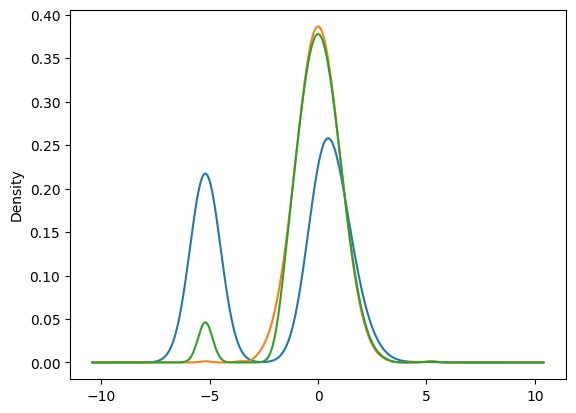

In [53]:
X_processed['5S_RRNA_chr9_41237440_41237557_-'].plot.kde()
X_processed['ZZZ3_chr1_77562416_77683419_-'].plot.kde()
X_processed['A2MP1_chr12_9228533_9275817_-'].plot.kde()
plt.show()

# K-mean  variation

In [17]:
from sklearn.cluster import KMeans

In [18]:
N_clusters = 10

In [19]:
clusterer = KMeans(n_clusters=N_clusters)
clusterer.fit(X_processed)

kmean_res = pd.DataFrame(data=clusterer.cluster_centers_, columns=keep_genes, 
                         index=['c_'+str(i) for i in range(10)])
cluster_assignments = pd.DataFrame(data=clusterer.labels_, index=X_processed.index, columns=['cluster'])

In [20]:
# Diagnosis, Gender, 'Age At Diagnosis (Days)', 'Relapse Status','Karnofsky Score', 'Site Of Resection', 
# 'Tumor Location', 'Anatomic Location In Lung', 'Morphology', 'Smoking Status', 'Tumor Stage', 'Response'
meta_data.columns

Index(['PatientID', 'Diagnosis', 'Sample Type', 'Gender', 'Ethnicity',
       'Age At Diagnosis (Days)', 'Age At Diagnosis (Years)', 'Vital Status ',
       'Overall Survival Status', 'Time To Overall Survival (Days)',
       'Time To Overall Survival From Treatment (Days)', 'Relapse Status',
       'Time To Relapse From Diagnosis (Days)', 'Event Status',
       'Time To Event From Diagnosis (Days)', 'Karnofsky Score',
       'Smoking Status', 'Pack Years', 'Histological Type', 'Morphology',
       'Site Of Resection', 'Tumor Location', 'Anatomic Location In Lung',
       'Tumor Stage', 'T-stage', 'N-stage', 'M-stage', 'R-stage',
       'Cancer Status After Resection', 'Drug Therapy Type', 'Drug Name',
       'Time To Drug Therapy (Days)', 'Radiation Therapy',
       'Time To Radiation Therapy (Days)', 'Response To Therapy',
       'Time To Therapy (Days)', 'Therapy Ongoing', 'New Tumor Event',
       'New Tumor Event Type', 'Time To New Tumor Event (Days)', 'Stage',
       'Tstage', '

## Sparse coding

In [21]:
# Marcenko Pastur -> get signal eigenvectors

In [22]:
from sklearn.decomposition import SparseCoder, SparsePCA, MiniBatchSparsePCA, PCA

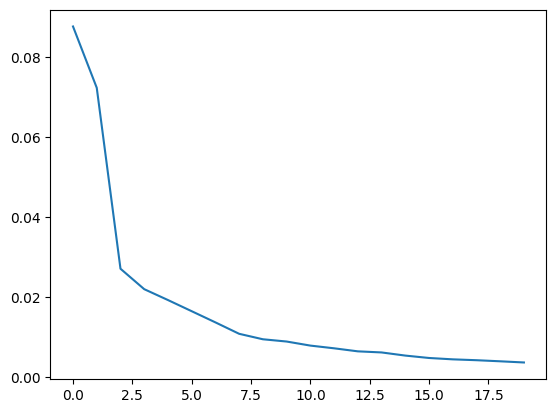

In [54]:
normal_pca = PCA(n_components=20)
normal_pca.fit(X_processed.iloc[:, :])
plt.plot(normal_pca.explained_variance_ratio_)
plt.show()

In [55]:
sparse_pca = MiniBatchSparsePCA(n_components=20, batch_size=10, n_iter=200)
sparse_pca.fit(X_processed.iloc[:, :])

MiniBatchSparsePCA(batch_size=10, n_components=20, n_iter=200)

In [56]:
non_zero_contributions = (np.abs(sparse_pca.components_)>0).sum(axis=0)

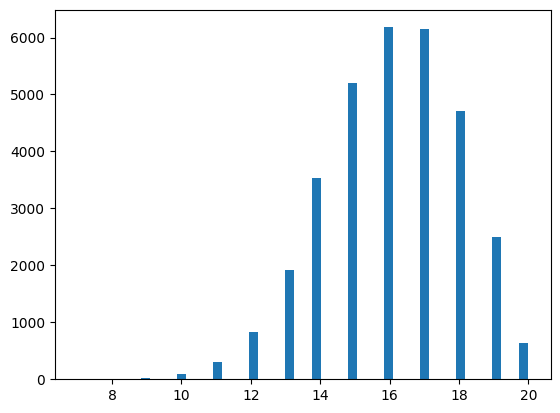

In [57]:
plt.hist(non_zero_contributions, bins=50);
plt.show()

In [84]:
_k = keep_genes[np.argwhere(non_zero_contributions>(sparse_pca.n_components_-5)).flatten()]
gene_include = [__k.split("_chr")[0] for __k in _k]

In [88]:
len(set(gene_include))

20037

# Concrete AE

In [77]:
from keras.datasets import mnist
from keras.layers import Dense, Dropout, LeakyReLU, ReLU
from sklearn.model_selection import train_test_split

In [90]:
def decoder(x):
    x = Dense(64)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.1)(x)
    x = Dense(64)(x)
    x = ReLU(0.2)(x)
    x = Dropout(0.1)(x)
    x = Dense(len(keep_genes))(x)
    return x

In [91]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [80]:
import math
from keras import backend as K
from keras import Model
from keras.layers import Layer, Softmax, Input
from keras.callbacks import EarlyStopping
from keras.initializers import Constant, glorot_normal
from keras.optimizers import adam_v2 as Adam

class ConcreteSelect(Layer):
    
    def __init__(self, output_dim, start_temp = 10.0, min_temp = 0.1, alpha = 0.99999, **kwargs):
        self.output_dim = output_dim
        self.start_temp = start_temp
        self.min_temp = K.constant(min_temp)
        self.alpha = K.constant(alpha)
        super(ConcreteSelect, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.temp = self.add_weight(name = 'temp', shape = [], initializer = Constant(self.start_temp), trainable = False)
        self.logits = self.add_weight(name = 'logits', shape = [self.output_dim, input_shape[1]], initializer = glorot_normal(), trainable = True)
        super(ConcreteSelect, self).build(input_shape)
        
    def call(self, X, training = None):
        uniform = K.random_uniform(self.logits.shape, K.epsilon(), 1.0)
        gumbel = -K.log(-K.log(uniform))
        temp = K.update(self.temp, K.maximum(self.min_temp, self.temp * self.alpha))
        noisy_logits = (self.logits + gumbel) / temp
        samples = K.softmax(noisy_logits)
        
        discrete_logits = K.one_hot(K.argmax(self.logits), self.logits.shape[1])
        
        self.selections = K.in_train_phase(samples, discrete_logits, training)
        Y = K.dot(X, K.transpose(self.selections))
        
        return Y
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
class StopperCallback(EarlyStopping):
    
    def __init__(self, mean_max_target = 0.998):
        self.mean_max_target = mean_max_target
        super(StopperCallback, self).__init__(monitor = '', patience = float('inf'), verbose = 1, mode = 'max', baseline = self.mean_max_target)
    
    def on_epoch_begin(self, epoch, logs = None):
        print('mean max of probabilities:', self.get_monitor_value(logs), '- temperature', K.get_value(self.model.get_layer('concrete_select').temp))
        #print( K.get_value(K.max(K.softmax(self.model.get_layer('concrete_select').logits), axis = -1)))
        #print(K.get_value(K.max(self.model.get_layer('concrete_select').selections, axis = -1)))
    
    def get_monitor_value(self, logs):
        monitor_value = K.get_value(K.mean(K.max(K.softmax(self.model.get_layer('concrete_select').logits), axis = -1)))
        return monitor_value


class ConcreteAutoencoderFeatureSelector():
    
    def __init__(self, K, output_function, num_epochs = 300, batch_size = None, 
                 learning_rate = 0.001, start_temp = 10.0, min_temp = 0.1, tryout_limit = 5,
                 mean_max_target=0.001, verbose=False):
        self.K = K
        self.output_function = output_function
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.start_temp = start_temp
        self.min_temp = min_temp
        self.tryout_limit = tryout_limit
        self.mean_max_target=mean_max_target
        self.verbose = verbose
        
    def fit(self, X, Y = None, val_X = None, val_Y = None):
        if Y is None:
            Y = X
        assert len(X) == len(Y)
        validation_data = None
        if val_X is not None and val_Y is not None:
            assert len(val_X) == len(val_Y)
            validation_data = (val_X, val_Y)
        
        if self.batch_size is None:
            self.batch_size = max(len(X) // 256, 16)
        
        num_epochs = self.num_epochs
        steps_per_epoch = (len(X) + self.batch_size - 1) // self.batch_size
        
        for i in range(self.tryout_limit):
            
            K.set_learning_phase(1)
            
            inputs = Input(shape = X.shape[1:])

            alpha = math.exp(math.log(self.min_temp / self.start_temp) / (num_epochs * steps_per_epoch))
            
            self.concrete_select = ConcreteSelect(self.K, self.start_temp, self.min_temp, alpha, name = 'concrete_select')

            selected_features = self.concrete_select(inputs)

            outputs = self.output_function(selected_features)

            self.model = Model(inputs, outputs)

            self.model.compile(Adam.Adam(self.learning_rate), loss = 'mean_squared_error')
            
            if self.verbose == True:
                print(self.model.summary())
            
            stopper_callback = StopperCallback(mean_max_target=self.mean_max_target)
            
            hist = self.model.fit(X, Y, self.batch_size, num_epochs, verbose = 1, callbacks = [stopper_callback], validation_data = validation_data)#, validation_freq = 10)
            
            if K.get_value(K.mean(K.max(K.softmax(self.concrete_select.logits, axis = -1)))) >= stopper_callback.mean_max_target:
                break
            
            num_epochs *= 2
        
        self.probabilities = K.get_value(K.softmax(self.model.get_layer('concrete_select').logits))
        self.indices = K.get_value(K.argmax(self.model.get_layer('concrete_select').logits))
            
        return self
    
    def get_indices(self):
        return K.get_value(K.argmax(self.model.get_layer('concrete_select').logits))
    
    def get_mask(self):
        return K.get_value(K.sum(K.one_hot(K.argmax(self.model.get_layer('concrete_select').logits), self.model.get_layer('concrete_select').logits.shape[1]), axis = 0))
    
    def transform(self, X):
        return X[self.get_indices()]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_support(self, indices = False):
        return self.get_indices() if indices else self.get_mask()
    
    def get_params(self):
        return self.model

In [89]:
selector = ConcreteAutoencoderFeatureSelector(K=2500,
                                              output_function=decoder, 
                                              learning_rate = 0.005,
                                              num_epochs=300,
                                              mean_max_target=0.001)

selector.fit(X_processed.loc[:, keep_genes], Y = X_processed.loc[:, keep_genes])

/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


mean max of probabilities: 3.1686886e-05 - temperature 10.0
Epoch 1/300


ValueError: in user code:

    File "/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/media/koekiemonster/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/keras/losses.py", line 1329, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 20186 and 32108 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_5/dense_21/BiasAdd, Cast)' with input shapes: [?,20186], [?,32108].


In [82]:
sum(selector.get_support()>0)

333

In [83]:
_k[selector.get_support()>0]

array(['AC005253.2_chr19_18557775_18561560_-',
       'AC005517.3_chr17_15506866_15507354_+',
       'AC005785.5_chr19_15383202_15383832_-',
       'AC006116.20_chr19_56272769_56310450_+',
       'AC007041.2_chr2_20239892_20241046_-',
       'AC007566.10_chr7_92457564_92491610_+',
       'AC008268.1_chr2_95666084_95668715_+',
       'AC009095.4_chr16_67614381_67616146_-',
       'AC010761.13_chr17_28670054_28672804_-',
       'AC011322.1_chr3_196983890_196987558_-',
       'AC017104.3_chr2_231456417_231456557_-',
       'AC019206.1_chr2_69902350_69902709_-',
       'AC020951.1_chr19_11856032_11858302_+',
       'AC024937.1_chr3_195960500_195960612_-',
       'AC064850.4_chr2_135510546_135511943_-',
       'AC069513.4_chr3_195655565_195657927_-',
       'AC074212.5_chr19_45764785_45769806_+',
       'AC087163.2_chr17_18010643_18011822_+',
       'AC090616.2_chr17_32141226_32143135_-',
       'AC091849.1_chr5_1569421_1569533_-',
       'AC092338.5_chr16_22382436_22407428_+',
       'AC09